In [1]:
! pip install torch torchvision matplotlib

  Using cached torch-2.3.0-cp311-cp311-win_amd64.whl.metadata (26 kB)
  Using cached torchvision-0.18.0-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
Using cached torch-2.3.0-cp311-cp311-win_amd64.whl (159.8 MB)
Using cached torchvision-0.18.0-cp311-cp311-win_amd64.whl (1.2 MB)
   ---------------------------------------- 0.0/228.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/228.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/228.5 MB 131.3 kB/s eta 0:29:01
   ---------------------------------------- 0.0/228.5 MB 163.8 kB/s eta 0:23:15
   ---------------------------------------- 0.0/228.5 MB 195.7 kB/s eta 0:19:28
   ---------------------------------------- 0.1/228.5 MB 403.5 kB/s eta 0:09:26
   ---------------------------------

In [2]:
# 필요한 라이브러리들을 임포트합니다.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
# 이미지를 텐서로 변환하고 정규화하는 변환을 정의합니다.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 학습 및 테스트 데이터셋을 불러오고, 위에서 정의한 변환을 적용합니다.
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터 로더를 설정하여 학습과 테스트 데이터를 배치로 처리할 수 있도록 합니다.
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


100%|██████████| 26421880/26421880 [01:46<00:00, 248657.31it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 97209.00it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1390513.74it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5072181.58it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



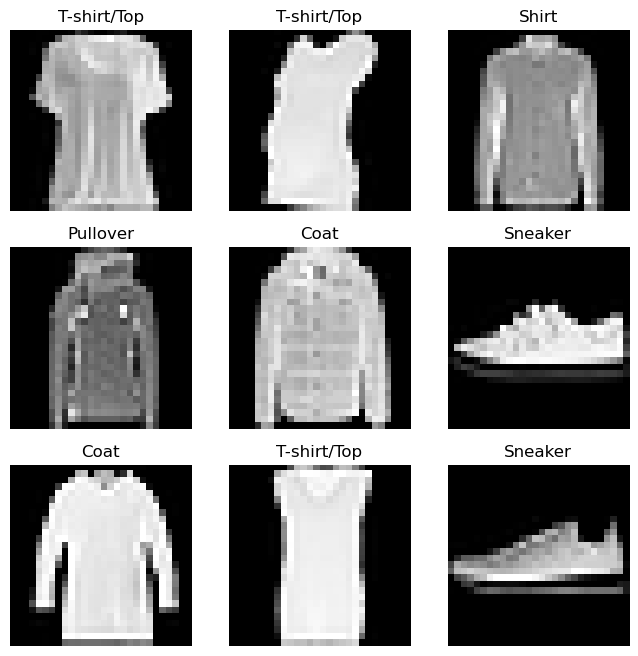

In [4]:
# 이미지와 레이블을 시각화합니다.
labels_map = {
    0: "T-shirt/Top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [5]:
# CNN 모델을 정의하는 클래스입니다. nn.Module을 상속받습니다.
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),  # 첫 번째 컨볼루션 레이어
            nn.BatchNorm2d(32),  # 배치 정규화
            nn.ReLU(),  # 활성화 함수
            nn.MaxPool2d(2)  # 풀링 레이어
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),  # 두 번째 컨볼루션 레이어
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(7*7*64, 1000)  # 첫 번째 완전 연결 레이어
        self.fc2 = nn.Linear(1000, 10)  # 두 번째 완전 연결 레이어
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [6]:
# FashionCNN 인스턴스를 생성합니다.
model = FashionCNN()

# 손실 함수로 교차 엔트로피 손실을 사용합니다.
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘으로 Adam을 사용하며, 학습률은 0.001로 설정합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

total_step = len(train_loader)
num_epochs = 5

# 에폭 수만큼 반복합니다.
for epoch in range(num_epochs):

    # 데이터 로더에서 배치 단위로 이미지와 레이블을 가져옵니다
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 매 100 스텝마다 현재 에폭, 스텝, 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/938], Loss: 0.8319
Epoch [1/5], Step [200/938], Loss: 0.9990
Epoch [1/5], Step [300/938], Loss: 0.3943
Epoch [1/5], Step [400/938], Loss: 0.4509
Epoch [1/5], Step [500/938], Loss: 0.3495
Epoch [1/5], Step [600/938], Loss: 0.5108
Epoch [1/5], Step [700/938], Loss: 0.5237
Epoch [1/5], Step [800/938], Loss: 0.2147
Epoch [1/5], Step [900/938], Loss: 0.4358
Epoch [2/5], Step [100/938], Loss: 0.4249
Epoch [2/5], Step [200/938], Loss: 0.2342
Epoch [2/5], Step [300/938], Loss: 0.2771
Epoch [2/5], Step [400/938], Loss: 0.4086
Epoch [2/5], Step [500/938], Loss: 0.2944
Epoch [2/5], Step [600/938], Loss: 0.4195
Epoch [2/5], Step [700/938], Loss: 0.3856
Epoch [2/5], Step [800/938], Loss: 0.2968
Epoch [2/5], Step [900/938], Loss: 0.2425
Epoch [3/5], Step [100/938], Loss: 0.2505
Epoch [3/5], Step [200/938], Loss: 0.2389
Epoch [3/5], Step [300/938], Loss: 0.1955
Epoch [3/5], Step [400/938], Loss: 0.2310
Epoch [3/5], Step [500/938], Loss: 0.2096
Epoch [3/5], Step [600/938], Loss:

In [7]:
# 모델을 평가 모드로 설정합니다. 
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # 전체 테스트 데이터셋에 대한 정확도를 계산하고 출력합니다.
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.47 %
